In [1]:
#
# Loading libraries
#

import numpy as np

from sklearn.datasets import fetch_openml

from scipy.spatial.distance import mahalanobis

from sklearn.decomposition import PCA

import daz

daz.set_daz()
daz.set_ftz()

np.random.seed(1)

In [2]:
#
# Fetching the dataset from server and scale 
# it for our purpose
#

# Fetch the datasets

mnist = fetch_openml("mnist_784")

# Normalize the dataset
mnist_data = mnist.data.values / np.max(mnist.data.values)

# Get Targets
mnist_target = mnist.target.astype(int)

# Convert labels to binaries
mnist_label = np.zeros((mnist_data.shape[0], 10))
for idx in range(mnist_data.shape[0]):
    mnist_label[idx,int(mnist.target[idx])] = 1

# mnist_data = np.load("../mnist_data.np.npy")
# mnist_label = np.load("../mnist_label.np.npy")

# Clean memory space of mnist
mnist = None

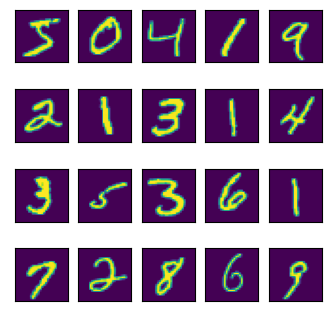

In [3]:
#
# Plot the digits
#

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

N_plot = 20

fig = plt.figure(figsize=(10/2.525, 10/2.525))

for idx in np.arange(N_plot):

    ax = fig.add_subplot(4,5,idx+1)
    ax.set_xticks([])
    ax.set_yticks([])


    im = ax.imshow(mnist_data[idx].reshape((28,28)))
    
#     divider = make_axes_locatable(ax)
    
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    
#     plt.colorbar(im, cax=cax)
#fig.tight_layout()
#fig.savefig("MNIST_example.pdf")

In [4]:
def y_of_x(x):
    return 0.5*(x + np.abs(x))

# The activation function for y

def y_of_x(x:np.ndarray, W_E_xy:np.ndarray = None, 
           W_I_yy:np.ndarray = None, noise = None
            ):
    
    if W_E_xy is None:
        return 0.5*(x + np.abs(x))

    if len(x.shape) == 1:
        y = np.zeros((W_E_xy.shape[0]))
    else:
        y = np.zeros((W_E_xy.shape[0], x.shape[1]))

    for t in range(20):
        input4y = np.matmul(W_E_xy, x) / np.sqrt(W_E_xy.shape[1])
        if W_I_yy is not None:
            input4y -= np.matmul(W_I_yy, (y)) / np.sqrt(W_I_yy.shape[1])
        if noise is not None:
            input4y += noise
        y += (-y + np.maximum(input4y, 0)) / np.sqrt(5.0)

    return y

def cal_fit_rate(W_E_xy:np.ndarray, 
                 data_sample:np.ndarray, target_sample:np.ndarray,
                 data_test:np.ndarray, target_test:np.ndarray):

    y = y_of_x(data_sample.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    W_yz = np.matmul(y, y.transpose())

    W_yz = np.matmul(y.transpose(), np.linalg.pinv(W_yz))

    W_yz = np.matmul(target_sample.transpose(), W_yz)
    
    
    

    y = y_of_x(data_test.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    z = np.matmul(W_yz, y)

    ans = 1.0 - np.sum(np.heaviside(
                    np.absolute(z.argmax(axis=0) - target_test.argmax(axis=1)) - 0.5
                    , 0)) / float(data_test.shape[0])

    return ans

def update_w(x, w):
    
    w_local = np.copy(w)
    
    x_last = np.zeros(w.shape[1])
    y_last = np.zeros(w.shape[0])
    
    for idx in range(x.shape[0]):
        
        xt = x[idx]
        
#        noise = np.heaviside(np.random.rand(w_local.shape[0]) - 0.95, 0)
        noise = np.random.normal(size=w_local.shape[0])
    
        y = y_of_x(xt, w_local, noise=noise)

        delta_w = np.outer(y, xt)
        
        for i in range(w_local.shape[0]):
            if np.sum(w_local[i]) >= 1.0:
                delta_w[i] = np.zeros_like(delta_w[i])
                
        for i in range(delta_w.shape[1]):
            delta_w[:,i] -= np.mean(delta_w[:,i])

        w_local += 0.02 * delta_w
                    
        for i in range(w_local.shape[1]):
            if np.max(w_local[:,i]) > 1:
                w_local[:,i] /= np.max(w_local[:,i])

        for i in range(w_local.shape[0]):
            if np.max(w_local[i]) < 0:
                w_local[i] = np.zeros_like(w_local[i])
                    
              
    return w_local

In [5]:
# Number of training samples 

N_train_sample = int(5000)

N_test = int(mnist_data.shape[0] * 0.1)

random_lists = []

for t in range(10):

    random_list = np.arange(mnist_data.shape[0])
    np.random.shuffle(random_list)
    
    random_lists.append(random_list)



# Number of middle layer

N_y = int(200)

for N_y in np.arange(100, 1001, 100):
    
    for t in range(len(random_lists)):
        
        #
        # Cutting the dataset to different matices
        #
        
        random_list = random_lists[t]

        # Copy the dataset to training and testing

        mnist_target_training = mnist_label[random_list[:N_train_sample]]
        mnist_data_training = mnist_data[random_list[:N_train_sample]]

        mnist_target_testing = mnist_label[random_list[(mnist_data.shape[0]-N_test):]]
        mnist_data_testing = mnist_data[random_list[(mnist_data.shape[0]-N_test):]]

        # Adding age factor for consideration

        W_E_xy = np.zeros((N_y, mnist_data.shape[1]))

        W_E_xy = update_w(mnist_data_training, W_E_xy)

        resulty = cal_fit_rate(W_E_xy, mnist_data_training, mnist_target_training,
                                         mnist_data_testing, mnist_target_testing)

        resultx = cal_fit_rate(np.eye(mnist_data_training.shape[1]), mnist_data_training, mnist_target_training,
                                         mnist_data_testing, mnist_target_testing)

        for pca_order in [50]:

            thenum = np.array([np.argmax(code) for code in mnist_target_training])

            pca_fit_x = PCA(pca_order)
            pca_fit_x.fit(mnist_data_training)
            x_pca = pca_fit_x.transform(mnist_data_training)

            y = y_of_x(mnist_data_training.transpose(), W_E_xy)

            pca_fit_y = PCA(pca_order)
            pca_fit_y.fit(y.transpose())
            y_pca = pca_fit_y.transform(y.transpose())

            record_hi = []

            for t in np.arange(0, 20, 20):

                for i in np.arange(10):
                    for j in np.arange(i):

                        digit_a=i
                        digit_b=j
                        start_c=t
                        end_d=t+y_pca.shape[1]

                        dy = mahalanobis(np.mean(y_pca[np.logical_or(thenum==digit_a, thenum==digit_a), start_c:end_d], axis=0),
                                   np.mean(y_pca[np.logical_or(thenum==digit_b, thenum==digit_b), start_c:end_d], axis=0),
                                   np.linalg.inv(np.cov(y_pca[np.logical_or(thenum==digit_b, thenum==digit_a), start_c:end_d].transpose())))

                        dx = mahalanobis(np.mean(x_pca[np.logical_or(thenum==digit_a, thenum==digit_a), start_c:end_d], axis=0),
                                   np.mean(x_pca[np.logical_or(thenum==digit_b, thenum==digit_b), start_c:end_d], axis=0),
                                   np.linalg.inv(np.cov(x_pca[np.logical_or(thenum==digit_b, thenum==digit_a), start_c:end_d].transpose())))

                        record_hi.append([dx,dy])


                        # print(i,j,dx, dy, dy-dx)

                out = np.mean(record_hi, axis=0)

                print(N_y, out[0], out[1], resultx, resulty)

100 1.868880267337584 1.8761421402125908 0.8237142857142857 0.8825714285714286
100 1.87202360684864 1.8755935897152984 0.8137142857142857 0.8665714285714285
100 1.8686672278744905 1.8808750766273596 0.8232857142857143 0.8901428571428571
100 1.8660106338526958 1.874944457791297 0.8127142857142857 0.8815714285714286
100 1.871819087195425 1.8822781675494051 0.8221428571428572 0.8785714285714286
100 1.8653736442512943 1.8791209857911424 0.8201428571428572 0.8827142857142857
100 1.8701491133297263 1.880491908837973 0.8247142857142857 0.8887142857142857
100 1.8687316882138951 1.8790422588297797 0.819 0.8727142857142858
100 1.8713028453064005 1.8802965881193137 0.8224285714285714 0.8744285714285714
100 1.8652722923070564 1.878807307606284 0.8164285714285714 0.8791428571428571
200 1.868940196402666 1.8857122666327926 0.8237142857142857 0.9135714285714286
200 1.8719566086484754 1.8871154102322771 0.8137142857142857 0.9122857142857143
200 1.868716695387725 1.8823827381411484 0.8232857142857143 0